In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot as gplt
import geoplot.crs as gcrs

%matplotlib inline

## Introduction
Below I attempt to accurately duplicate the Block Retrieval Method described in this [link](https://help.alteryx.com/11.8/Allocate_Retrieval_Methodology.htm). Per the description, the steps are:

```Allocate first identifies which block centroids are contained within it. Block centroids found inside the polygon are associated within other block centroids having the same block group code. The population and household counts of the blocks are aggregated, expressed as a percentage of the corresponding block groups total population and household count and then applied to each of the block group attributes being requested for an Allocate database or report.```

The approach I took does not follow the order of the steps verbatim but I believe the end math is still the same. At a high level my approach:
    * get census blocks (2010 census) and determine which census blocks they lay within
    * calculate population proportion each census block contributes to the total census block group population
    * get ACS demographic data (in this case, # of people aged 65+) and allocate the data to each census block based on its population proportion
    * calculate centroid of each census block
    * get the trade shape (in this case neighborhoods) and determine which block centroids are in which neighborhoods
    * sum up the # of people aged 65+ in each neighborhood by adding up the contribution of each census block laying within the neighborhood
    


In [2]:
# get the census blocks
or_blocks = gpd.read_file("../data/census_blocks_2010/tabblock2010_41_pophu/tabblock2010_41_pophu.shp")

In [3]:
or_blocks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 196621 entries, 0 to 196620
Data columns (total 9 columns):
STATEFP10     196621 non-null object
COUNTYFP10    196621 non-null object
TRACTCE10     196621 non-null object
BLOCKCE       196621 non-null object
BLOCKID10     196621 non-null object
PARTFLG       196621 non-null object
HOUSING10     196621 non-null int64
POP10         196621 non-null int64
geometry      196621 non-null object
dtypes: int64(2), object(7)
memory usage: 13.5+ MB


In [4]:
or_blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry
0,41,001,950100,1377,410019501001377,N,0,0,"POLYGON ((-118.383665 44.690009, -118.383829 4..."
1,41,001,950100,1309,410019501001309,N,0,0,"POLYGON ((-118.39982 44.657918, -118.399959 44..."
2,41,001,950100,1946,410019501001946,N,0,0,"POLYGON ((-118.405203 44.641425, -118.405266 4..."
3,41,001,950100,1340,410019501001340,N,2,0,"POLYGON ((-118.478474 44.67859199999999, -118...."
4,41,001,950100,1402,410019501001402,N,0,0,"POLYGON ((-118.430122 44.693929, -118.43011 44..."


In [5]:
or_blocks.crs

{'init': 'epsg:4269'}

In [6]:
# get the block groups
or_bg = gpd.read_file("../data/ACS/cb_2016_41_bg_500k/cb_2016_41_bg_500k.shp")

In [7]:
or_bg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 11 columns):
STATEFP     2628 non-null object
COUNTYFP    2628 non-null object
TRACTCE     2628 non-null object
BLKGRPCE    2628 non-null object
AFFGEOID    2628 non-null object
GEOID       2628 non-null object
NAME        2628 non-null object
LSAD        2628 non-null object
ALAND       2628 non-null int64
AWATER      2628 non-null int64
geometry    2628 non-null object
dtypes: int64(2), object(9)
memory usage: 225.9+ KB


In [8]:
or_bg.head(3)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,41,005,020900,1,1500000US410050209001,410050209001,1,BG,443749,0,"POLYGON ((-122.63656 45.461474, -122.626278 45..."
1,41,047,002102,2,1500000US410470021022,410470021022,2,BG,287579,0,"POLYGON ((-123.05852 44.89242, -123.0575 44.89..."
2,41,029,000601,2,1500000US410290006012,410290006012,2,BG,2039310,0,"POLYGON ((-122.840623 42.32259699999999, -122...."


In [9]:
# spatial join census blocks to block groups, based on which blocks are within which block groups
joined = gpd.sjoin(or_blocks, or_bg, op='within')

In [10]:
joined.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
0,41,001,950100,1377,410019501001377,N,0,0,"POLYGON ((-118.383665 44.690009, -118.383829 4...",693,41,001,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275
1,41,001,950100,1309,410019501001309,N,0,0,"POLYGON ((-118.39982 44.657918, -118.399959 44...",693,41,001,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275
3,41,001,950100,1340,410019501001340,N,2,0,"POLYGON ((-118.478474 44.67859199999999, -118....",693,41,001,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275
4,41,001,950100,1402,410019501001402,N,0,0,"POLYGON ((-118.430122 44.693929, -118.43011 44...",693,41,001,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275
5,41,001,950100,1426,410019501001426,N,0,0,"POLYGON ((-118.419952 44.650307, -118.419769 4...",693,41,001,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275


In [11]:
# sum up population and housing units by block group

bg_populations = joined[['GEOID', 'POP10', 'HOUSING10']].groupby('GEOID').sum().reset_index()

In [12]:
bg_populations.head()

,GEOID,POP10,HOUSING10
0,410019501001,687,844
1,410019501002,618,287
2,410019501003,584,307
3,410019502001,698,296
4,410019502002,972,477


In [13]:
bg_populations = bg_populations.rename(columns={'POP10':'Total_Population', 'HOUSING10':'Total_Housing_Units'})
bg_populations.head(3)

,GEOID,Total_Population,Total_Housing_Units
0,410019501001,687,844
1,410019501002,618,287
2,410019501003,584,307


In [14]:
# merge the totals back onto joined
joined = joined.merge(bg_populations, on='GEOID', how='inner')
joined.head(3)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,index_right,...,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Total_Population,Total_Housing_Units
0,41,001,950100,1377,410019501001377,N,0,0,"POLYGON ((-118.383665 44.690009, -118.383829 4...",693,...,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275,687,844
1,41,001,950100,1309,410019501001309,N,0,0,"POLYGON ((-118.39982 44.657918, -118.399959 44...",693,...,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275,687,844
2,41,001,950100,1340,410019501001340,N,2,0,"POLYGON ((-118.478474 44.67859199999999, -118....",693,...,950100,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275,687,844


In [15]:
joined['pop_weight'] = joined['POP10']/joined['Total_Population']
joined.head(3)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,index_right,...,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Total_Population,Total_Housing_Units,pop_weight
0,41,001,950100,1377,410019501001377,N,0,0,"POLYGON ((-118.383665 44.690009, -118.383829 4...",693,...,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275,687,844,0.0
1,41,001,950100,1309,410019501001309,N,0,0,"POLYGON ((-118.39982 44.657918, -118.399959 44...",693,...,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275,687,844,0.0
2,41,001,950100,1340,410019501001340,N,2,0,"POLYGON ((-118.478474 44.67859199999999, -118....",693,...,1,1500000US410019501001,410019501001,1,BG,2205985801,13837275,687,844,0.0


In [16]:
# let's make a concise lookup table only with the columns we'll need later
# NOTE: 'BLOCKID10' is block ID and 'GEOID' is block group ID
lookup = joined[['BLOCKID10','GEOID','POP10', 'Total_Population', 'pop_weight']]

In [17]:
lookup.tail()

,BLOCKID10,GEOID,POP10,Total_Population,pop_weight
142771,410710302012002,410710302012,416,927,0.448759
142772,410710302012004,410710302012,0,927,0.000000
142773,410710302012001,410710302012,36,927,0.038835
142774,410710302012003,410710302012,379,927,0.408846
142775,410710302012009,410710302012,5,927,0.005394


Time to bring in some demographic data from ACS estimates, aggregated by block group, and allocate to blocks by population weighting. Then we'll calculate the centroid of each census block and reallocate the demographic data by census block to the higher trade shape -- in this case, neighborhoods. If the centroid of the block is within the higher trade shape, then we'll allocate it's population weighted data to that shape.

In [18]:
# let's try one individual 2016 ACS estimates table B01001 - SEX BY AGE

sex_age_table = pd.read_csv("../data/ACS/ACS_2016_tables/ACS_16_5YR_B01001_with_ann.csv", skiprows=1)

In [19]:
sex_age_table.head(3)

,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Male:,Margin of Error; Male:,Estimate; Male: - Under 5 years,Margin of Error; Male: - Under 5 years,Estimate; Male: - 5 to 9 years,...,Estimate; Female: - 67 to 69 years,Margin of Error; Female: - 67 to 69 years,Estimate; Female: - 70 to 74 years,Margin of Error; Female: - 70 to 74 years,Estimate; Female: - 75 to 79 years,Margin of Error; Female: - 75 to 79 years,Estimate; Female: - 80 to 84 years,Margin of Error; Female: - 80 to 84 years,Estimate; Female: - 85 years and over,Margin of Error; Female: - 85 years and over
0,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",885,143,443,81,14,12,5,...,24,16,14,9,21,14,22,17,13,10
1,1500000US410019501002,410019501002,"Block Group 2, Census Tract 9501, Baker County...",1009,174,412,74,24,17,35,...,45,46,28,20,33,19,1,3,4,6
2,1500000US410019501003,410019501003,"Block Group 3, Census Tract 9501, Baker County...",1216,181,578,91,33,41,36,...,39,23,36,33,0,12,0,12,17,17


In [20]:
list(sex_age_table)

['Id',
 'Id2',
 'Geography',
 'Estimate; Total:',
 'Margin of Error; Total:',
 'Estimate; Male:',
 'Margin of Error; Male:',
 'Estimate; Male: - Under 5 years',
 'Margin of Error; Male: - Under 5 years',
 'Estimate; Male: - 5 to 9 years',
 'Margin of Error; Male: - 5 to 9 years',
 'Estimate; Male: - 10 to 14 years',
 'Margin of Error; Male: - 10 to 14 years',
 'Estimate; Male: - 15 to 17 years',
 'Margin of Error; Male: - 15 to 17 years',
 'Estimate; Male: - 18 and 19 years',
 'Margin of Error; Male: - 18 and 19 years',
 'Estimate; Male: - 20 years',
 'Margin of Error; Male: - 20 years',
 'Estimate; Male: - 21 years',
 'Margin of Error; Male: - 21 years',
 'Estimate; Male: - 22 to 24 years',
 'Margin of Error; Male: - 22 to 24 years',
 'Estimate; Male: - 25 to 29 years',
 'Margin of Error; Male: - 25 to 29 years',
 'Estimate; Male: - 30 to 34 years',
 'Margin of Error; Male: - 30 to 34 years',
 'Estimate; Male: - 35 to 39 years',
 'Margin of Error; Male: - 35 to 39 years',
 'Estimate; 

In [21]:
# get rid of 'Margin of Error' columns
sex_age_table = sex_age_table[sex_age_table.columns.drop(list(sex_age_table.filter(regex='Margin')))]

In [22]:
list(sex_age_table)

['Id',
 'Id2',
 'Geography',
 'Estimate; Total:',
 'Estimate; Male:',
 'Estimate; Male: - Under 5 years',
 'Estimate; Male: - 5 to 9 years',
 'Estimate; Male: - 10 to 14 years',
 'Estimate; Male: - 15 to 17 years',
 'Estimate; Male: - 18 and 19 years',
 'Estimate; Male: - 20 years',
 'Estimate; Male: - 21 years',
 'Estimate; Male: - 22 to 24 years',
 'Estimate; Male: - 25 to 29 years',
 'Estimate; Male: - 30 to 34 years',
 'Estimate; Male: - 35 to 39 years',
 'Estimate; Male: - 40 to 44 years',
 'Estimate; Male: - 45 to 49 years',
 'Estimate; Male: - 50 to 54 years',
 'Estimate; Male: - 55 to 59 years',
 'Estimate; Male: - 60 and 61 years',
 'Estimate; Male: - 62 to 64 years',
 'Estimate; Male: - 65 and 66 years',
 'Estimate; Male: - 67 to 69 years',
 'Estimate; Male: - 70 to 74 years',
 'Estimate; Male: - 75 to 79 years',
 'Estimate; Male: - 80 to 84 years',
 'Estimate; Male: - 85 years and over',
 'Estimate; Female:',
 'Estimate; Female: - Under 5 years',
 'Estimate; Female: - 5 to 9

In [23]:
# create new df age_65_plus to only summary and store data for total estimated population age 65+ 
age_65_plus = sex_age_table[sex_age_table.columns[:3]] # create the df from first 3 columns of age_sex_table
# sum up total age 65+ from both sexes
age_65_plus['age_65_count'] = sex_age_table[sex_age_table.columns[22:28]].sum(axis=1) + sex_age_table[sex_age_table.columns[46:52]].sum(axis=1)

C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
age_65_plus.head(10)

,Id,Id2,Geography,age_65_count
0,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259
1,1500000US410019501002,410019501002,"Block Group 2, Census Tract 9501, Baker County...",214
2,1500000US410019501003,410019501003,"Block Group 3, Census Tract 9501, Baker County...",227
3,1500000US410019502001,410019502001,"Block Group 1, Census Tract 9502, Baker County...",296
4,1500000US410019502002,410019502002,"Block Group 2, Census Tract 9502, Baker County...",221
5,1500000US410019502003,410019502003,"Block Group 3, Census Tract 9502, Baker County...",241
6,1500000US410019503001,410019503001,"Block Group 1, Census Tract 9503, Baker County...",172
7,1500000US410019503002,410019503002,"Block Group 2, Census Tract 9503, Baker County...",312
8,1500000US410019503003,410019503003,"Block Group 3, Census Tract 9503, Baker County...",172
9,1500000US410019504001,410019504001,"Block Group 1, Census Tract 9504, Baker County...",323


In [25]:
age_65_plus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2634 entries, 0 to 2633
Data columns (total 4 columns):
Id              2634 non-null object
Id2             2634 non-null int64
Geography       2634 non-null object
age_65_count    2634 non-null int64
dtypes: int64(2), object(2)
memory usage: 82.4+ KB


In [26]:
age_65_plus.describe()

,Id2,age_65_count
count,2.634000e+03,2634.000000
mean,4.103968e+11,240.916477
std,1.999910e+08,166.437101
min,4.100195e+11,0.000000
25%,4.102795e+11,126.000000
50%,4.104303e+11,204.000000
75%,4.105101e+11,317.000000
max,4.107103e+11,1301.000000


In [27]:
age_65_plus.sum()

Id              1500000US4100195010011500000US4100195010021500...
Id2                                              1080985293125971
Geography       Block Group 1, Census Tract 9501, Baker County...
age_65_count                                               634574
dtype: object

~634.5K people aged 65+ in OR from this data

In [28]:
lookup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142776 entries, 0 to 142775
Data columns (total 5 columns):
BLOCKID10           142776 non-null object
GEOID               142776 non-null object
POP10               142776 non-null int64
Total_Population    142776 non-null int64
pop_weight          142726 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.5+ MB


In [29]:
age_65_plus['Id2'] = age_65_plus['Id2'].astype(str)
block_allocation = age_65_plus.merge(lookup, right_on='GEOID', left_on='Id2', how='inner')
block_allocation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142776 entries, 0 to 142775
Data columns (total 9 columns):
Id                  142776 non-null object
Id2                 142776 non-null object
Geography           142776 non-null object
age_65_count        142776 non-null int64
BLOCKID10           142776 non-null object
GEOID               142776 non-null object
POP10               142776 non-null int64
Total_Population    142776 non-null int64
pop_weight          142726 non-null float64
dtypes: float64(1), int64(3), object(5)
memory usage: 10.9+ MB


C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
block_allocation

,Id,Id2,Geography,age_65_count,BLOCKID10,GEOID,POP10,Total_Population,pop_weight
0,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001377,410019501001,0,687,0.000000
1,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001309,410019501001,0,687,0.000000
2,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001340,410019501001,0,687,0.000000
3,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001402,410019501001,0,687,0.000000
4,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001426,410019501001,0,687,0.000000
5,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001335,410019501001,0,687,0.000000
6,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001492,410019501001,4,687,0.005822
7,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001508,410019501001,0,687,0.000000
8,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001504,410019501001,0,687,0.000000
9,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001528,410019501001,0,687,0.000000


In [31]:
block_allocation['pop_weighted_output'] = block_allocation['pop_weight']*block_allocation['age_65_count']
block_allocation.head(10)


,Id,Id2,Geography,age_65_count,BLOCKID10,GEOID,POP10,Total_Population,pop_weight,pop_weighted_output
0,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001377,410019501001,0,687,0.000000,0.000000
1,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001309,410019501001,0,687,0.000000,0.000000
2,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001340,410019501001,0,687,0.000000,0.000000
3,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001402,410019501001,0,687,0.000000,0.000000
4,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001426,410019501001,0,687,0.000000,0.000000
5,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001335,410019501001,0,687,0.000000,0.000000
6,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001492,410019501001,4,687,0.005822,1.508006
7,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001508,410019501001,0,687,0.000000,0.000000
8,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001504,410019501001,0,687,0.000000,0.000000
9,1500000US410019501001,410019501001,"Block Group 1, Census Tract 9501, Baker County...",259,410019501001528,410019501001,0,687,0.000000,0.000000


In [32]:
# check our logic: sum of pop_weighted_output should equal sum of age_65_count above (~635K)
block_allocation['pop_weighted_output'].sum()

632138.0

### now merge this onto polygons for blocks, calculate centroid points, then do "within" spatial join to trade geometry and sum

In [33]:
or_blocks_data = or_blocks.merge(block_allocation[['BLOCKID10','pop_weighted_output']], on="BLOCKID10", how='left')

In [34]:
or_blocks_data['block_centroids'] = or_blocks_data['geometry'].centroid
or_blocks_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 196621 entries, 0 to 196620
Data columns (total 11 columns):
STATEFP10              196621 non-null object
COUNTYFP10             196621 non-null object
TRACTCE10              196621 non-null object
BLOCKCE                196621 non-null object
BLOCKID10              196621 non-null object
PARTFLG                196621 non-null object
HOUSING10              196621 non-null int64
POP10                  196621 non-null int64
geometry               196621 non-null object
pop_weighted_output    142726 non-null float64
block_centroids        196621 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 18.0+ MB


In [35]:
or_blocks_data = or_blocks_data[['BLOCKID10','pop_weighted_output','block_centroids']]

In [36]:
# since or_blocks_data now is pandas df, convert to geodf
or_blocks_data = GeoDataFrame(or_blocks_data[['BLOCKID10','pop_weighted_output','block_centroids']],
                         crs= {'init': 'epsg:4326'},
                         geometry='block_centroids')

### bring in neighborhood ahapefiles

In [37]:
neighborhoods = gpd.read_file("../data/pdx neighborhoods/Neighborhood_Boundaries.shp")

In [38]:
#reproject to get area in feet
neighborhoods_2992 = neighborhoods.to_crs({'init': 'epsg:2992'})

In [39]:
neighborhoods['area'] = neighborhoods_2992['geometry'].area
neighborhoods.head()

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,geometry,area
0,1,ST. JOHNS,None,None,NPNS,HORZ,32669.063081,St. Johns,POLYGON ((-122.7923191957859 45.61978371722063...,3.070305e+08
1,2,HAYDEN ISLAND NEIGHBORHOOD NETWORK,None,None,NPNS,HORZ,27707.083425,Hayden Island Neighborhood Network,POLYGON ((-122.7475117396571 45.64005156754342...,8.976788e+07
2,3,LINNTON,None,None,NWNW,HORZ,52741.719772,Linnton,POLYGON ((-122.8237089611819 45.60615857772244...,6.071105e+07
3,4,FOREST PARK/LINNTON,None,Y,NWNW,HORZ,57723.635350,Forest Park/Linnton,POLYGON ((-122.8231909270121 45.60615651892255...,1.686187e+08
4,5,KENTON,ALBINA,None,NPNS,VERT,19182.565606,Kenton,POLYGON ((-122.6816166816783 45.60713031403424...,9.577301e+07


In [40]:
# neighborhoods are in 4326 which is Hack OR informal "standard". I'll reproject the blocks to 4326
or_blocks_data = or_blocks_data.to_crs({'init': 'epsg:4326'})

In [41]:
# spatial join blocks and neighborhoods to determine which blocks are within which neighborhoods
final = gpd.sjoin(or_blocks_data, neighborhoods, op='within')

In [42]:
final.head()

,BLOCKID10,pop_weighted_output,block_centroids,index_right,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,area
7971,410050222061002,NaN,POINT (-122.5699360483201 45.45829293666745),93,94,LENTS,OUTER SE,None,EPNO,VERT,20468.169066,Lents,8.952597e+07
10302,410050222062010,14.64831,POINT (-122.5673271995655 45.45988650595211),93,94,LENTS,OUTER SE,None,EPNO,VERT,20468.169066,Lents,8.952597e+07
12719,410050222061001,NaN,POINT (-122.570960836157 45.45845882227357),93,94,LENTS,OUTER SE,None,EPNO,VERT,20468.169066,Lents,8.952597e+07
13944,410050222062009,NaN,POINT (-122.5667720421907 45.45969239986879),93,94,LENTS,OUTER SE,None,EPNO,VERT,20468.169066,Lents,8.952597e+07
13945,410050222061013,NaN,POINT (-122.5693014056347 45.45953607493755),93,94,LENTS,OUTER SE,None,EPNO,VERT,20468.169066,Lents,8.952597e+07


In [43]:
rollup = pd.DataFrame(final.groupby('NAME')['pop_weighted_output'].sum()).reset_index()

In [44]:
rollup.sort_values('pop_weighted_output', ascending="False")

,NAME,pop_weighted_output
63,LLOYD DISTRICT COMMUNITY ASSN./SULLIVAN'S GULCH,0.000000
116,WOODLAND PARK,0.000000
7,ARGAY/WILKES COMMUNITY GROUP,0.000000
106,SULLIVAN'S GULCH/GRANT PARK,0.000000
9,ARLINGTON HEIGHTS/SYLVAN-HIGHLANDS,0.000000
46,HAZELWOOD/MILL PARK,0.000000
69,MC UNCLAIMED #11,0.406586
108,SUNDERLAND ASSOCIATION OF NEIGHBORS,1.063202
15,BOISE/ELIOT,2.113586
71,MC UNCLAIMED #14,2.138520


In [45]:
population_df = neighborhoods.merge(rollup, on='NAME', how='inner')

In [46]:
population_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 11 columns):
OBJECTID               126 non-null int64
NAME                   126 non-null object
COMMPLAN               57 non-null object
SHARED                 24 non-null object
COALIT                 126 non-null object
HORZ_VERT              122 non-null object
Shape_Leng             126 non-null float64
MAPLABEL               126 non-null object
geometry               126 non-null object
area                   126 non-null float64
pop_weighted_output    126 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 11.8+ KB


In [47]:
#population_df = population_df.drop_duplicates('')
population_df['pop_weighted_output'].sum()

77036.07745375599

Text(0.5,1,'Population of age 65+ by Neighorhood')

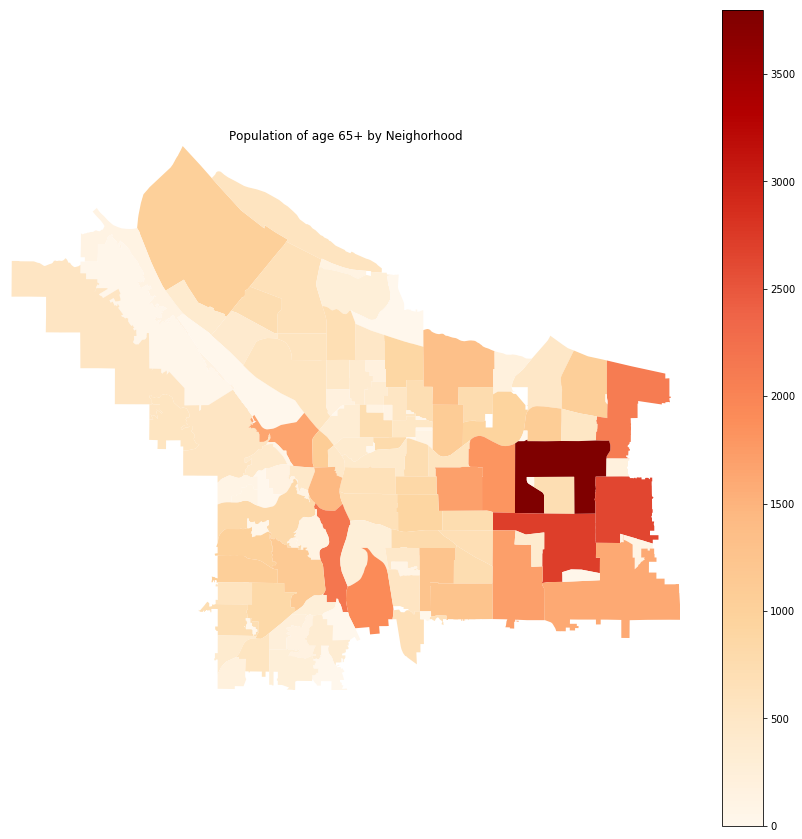

In [48]:
# plot choropleth of population by neighborhood unit

gplt.choropleth(population_df,
                hue=population_df['pop_weighted_output'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(15, 15))

plt.title("Population of age 65+ by Neighorhood")

In [49]:
# plot choropleth of population density by neighborhood unit (persons/sqare mile)
population_df['pop_density'] = population_df['pop_weighted_output']/(population_df['area']*3.58701e-8)

In [50]:
population_df.sort_values('pop_density', ascending=False).head(10)

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,geometry,area,pop_weighted_output,pop_density
109,126,ASHCREEK,SOUTHWEST,None,SWNI,HORZ,83.137004,Ashcreek,POLYGON ((-122.7268505168685 45.45830830872709...,6.218841e+01,717.716715,3.217444e+08
111,129,ASHCREEK,SOUTHWEST,None,SWNI,VERT,134.874678,Ashcreek,POLYGON ((-122.7254674526907 45.46045854340213...,4.852445e+03,717.716715,4.123442e+06
73,99,SOUTHWEST HILLS RESIDENTIAL LEAGUE,SOUTHWEST,None,SWNI,HORZ,1067.776688,Southwest Hills Residential League,POLYGON ((-122.6956393428392 45.49109271601252...,2.872734e+05,825.622012,8.012229e+04
125,130,ASHCREEK/CRESTWOOD,SOUTHWEST,Y,SWNI,HORZ,173.825878,Ashcreek,POLYGON ((-122.7274849493429 45.45841483015463...,1.000165e+04,6.657437,1.855679e+04
110,128,ASHCREEK,SOUTHWEST,None,SWNI,HORZ,3859.978426,Ashcreek,"POLYGON ((-122.721935554573 45.45467318142971,...",1.541502e+06,717.716715,1.298005e+04
114,120,ARDENWALD-JOHNSON CREEK,None,None,SEUL,HORZ,3672.769047,Ardenwald-Johnson Creek,POLYGON ((-122.6158620034288 45.46255792240125...,1.436168e+06,654.866492,1.271203e+04
70,74,GOOSE HOLLOW FOOTHILLS LEAGUE/SOUTHWEST HILLS ...,None,Y,NWNW/SWNI,HORZ,1331.415255,Goose Hollow Foothills League/Southwest Hills ...,POLYGON ((-122.6972847447243 45.51830330443261...,4.681134e+05,129.041995,7.685063e+03
42,44,ALAMEDA/BEAUMONT-WILSHIRE,None,Y,NECN,VERT,1387.295670,Alameda/Beaumont-Wilshire,POLYGON ((-122.6307030944923 45.54602108404239...,4.704706e+05,59.471429,3.524060e+03
51,55,SULLIVAN'S GULCH,None,None,NECN,HORZ,5601.661854,Sullivan'S Gulch,POLYGON ((-122.6504879397544 45.53504337587768...,7.644058e+06,791.000000,2.884828e+03
46,50,PEARL DISTRICT,None,None,NWNW,VERT,6505.417726,Pearl District,POLYGON ((-122.6829216041044 45.53797896676441...,1.241998e+07,1094.493938,2.456745e+03


4 out of the top 5 neighborhoods highest in density of persons aged 65+ have Ashcreek in their names. They are outliers and there may be something in the block allocation method I've used that is erroneously skewing the results high. I will plot the top 5 neighborhoods on their own choropleth and then plot the remaining neighborhoods on their own so as to not lose too much resolution in the choropleth maps due to the range of values spanning too many orders of magnitude.

In [51]:
population_highest_density_df = population_df[population_df['pop_density'] > 1e4] #  split out top 5 most dense for plotting
population_lower_density_df = population_df[population_df['pop_density'] < 1e4] #  split out rest of the lower density neighborhoods for plotting

Text(0.5,1,'Population desnsity (persons/mi^2) of age 65+ of 5 most dense neighorhoods')

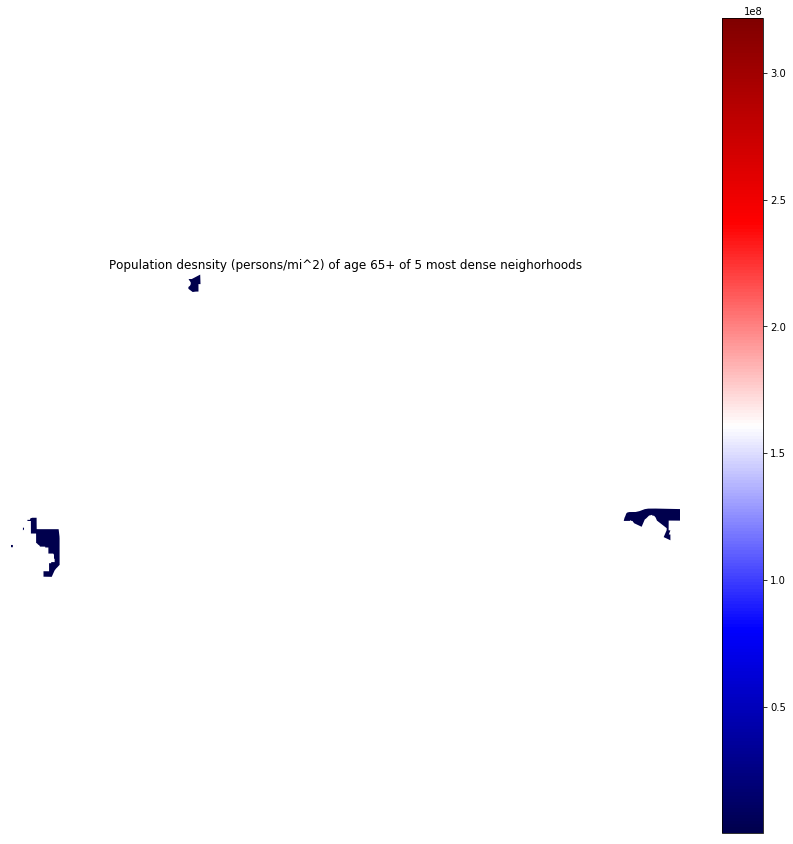

In [52]:
gplt.choropleth(population_highest_density_df,
                hue=population_highest_density_df['pop_density'], # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='seismic',
                linewidth=2,
                k=None,
                legend=True,
                scheme='equal_interval',
                figsize=(15, 15))

plt.title("Population desnsity (persons/mi^2) of age 65+ of 5 most dense neighorhoods")

This would look much better with a basemap to determine relative locations, but we can see these SW PDX Ashcreek neighborhoods are quite small and the accuracy of any allocation method is likely to decrease the smaller the trade shape is relative to its block groups and blocks. 

Text(0.5,1,'Population desnsity (persons/mi^2) of age 65+ of neighorhoods excluding the top 5')

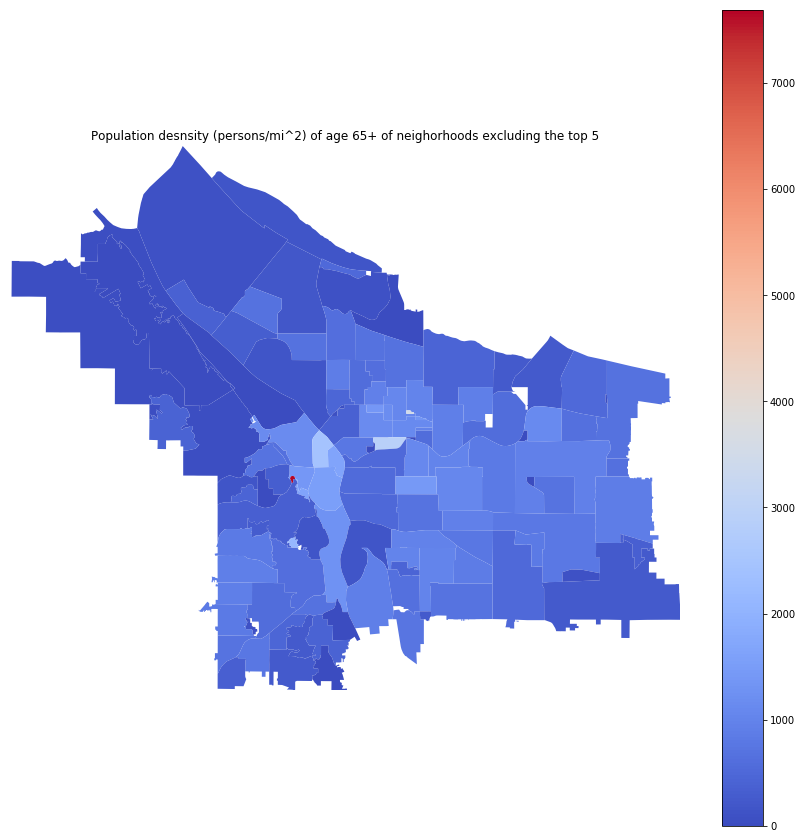

In [53]:
gplt.choropleth(population_lower_density_df,
                hue=population_lower_density_df['pop_density'], # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap="coolwarm",
                linewidth=0.5,
                k=None,
                legend=True,
                scheme='equal_interval',
                figsize=(15, 15))

plt.title("Population desnsity (persons/mi^2) of age 65+ of neighorhoods excluding the top 5")

I believe the approach I've followed above to allocate demographic properties accurately follows the Block Retrieval method. I will check in with the team GIS experts to verify.